**Submission**

- Submissions are evaluated on the Sharpe Ratio of the daily spread returns.

**Sharpe Ratio**

- It represents the additional amount of return that an investor receives per unit of increase in risk.

- It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment returns.

- In finance, the Sharpe ratio (also known as the Sharpe index, the Sharpe measure, and the reward-to-variability ratio) measures the performance of an investment such as a security or portfolio compared to a risk-free asset, after adjusting for its risk.

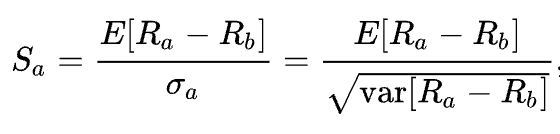

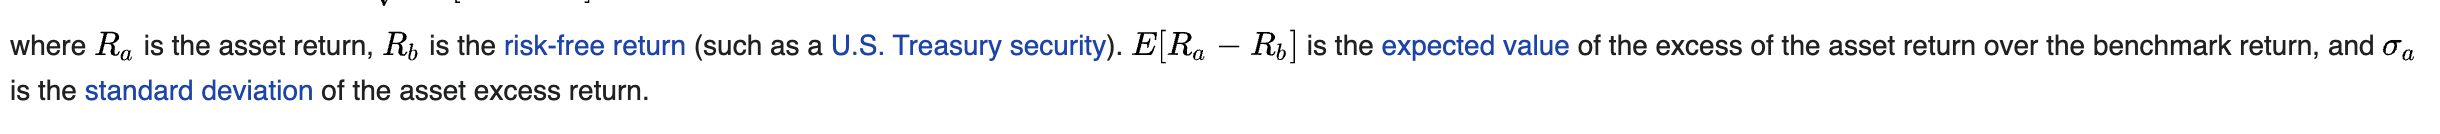

In [ ]:
import os
import numpy as np
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import jpx_tokyo_market_prediction

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**Evaluation Code - Python Implementation**

In [ ]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

**The following rules are used to determine which stocks are available for investment.**

- The top 2,000 common stocks by market capitalization that have been listed for at least one year as of 2021-12-31 are eligible for investment.

- If a stock is designated as Securities Under Supervision or Securities to Be Delisted during the private period, it will be excluded from investment after the date of designation.

- When calculating the score, the adjusted stock price is used.

**Sample Submission**

In [ ]:
sample_submission = pd.read_csv('/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv')

In [ ]:
sample_submission.head(3)
sample_submission.tail(3)

**Observation**

- 112K records 
- Data starts from 6th December 2021 to 28th February 2022

In [ ]:
sample_submission.describe(include = 'all')

**Observation**

- 112K records
- Submission has to be submitted for 56 days
- Min Security code : 1301 | Max Security Code : 9997
- Min Rank : 0 | Max Rank : 1999

In [ ]:
sample_submission['Date'].value_counts().sort_index()

**Observation:**

- 56 working days b/w 2021-12-06 and 2022-02-28
- All days have 2K records 

In [ ]:
sample_submission.nunique()

**Observation**

- 2K Securities
- 2K Rank
- 56 Dates

**Heuristics**

- stock_prices.csv : The core file of interest. Includes the daily closing price for each stock and the target column.

In [ ]:
stock_prices = pd.read_csv('/kaggle/input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv')

**Understanding Stock Prices Data**

In [ ]:
stock_prices.shape
stock_prices.head()
stock_prices.tail()

In [ ]:
stock_prices.nunique()

In [ ]:
stock_prices['Date'].min(), stock_prices['Date'].max()

**Oservation:**

- 2332531 records and 2332531 unique ids
- 1202 trading days between 20217-01-04 and 2021-12-03
- 2K securities code

In [ ]:
stock_prices.describe(include = 'all').T

**Observation**

- RowId is a combination of Date and SecuritiesCode
- 

**Basic Logical Imputation**

- Get average volume traded by each securities
- Get Average daily change in price by securities code
- Multiply these and sort them to get a rank based on complete data

In [ ]:
securities_avg_vol_traded = (stock_prices.groupby('SecuritiesCode')['Volume']
                                         .mean()
                                         .reset_index()
                                         .rename(columns = {'Volume' : 'AvergaeVolume'}))
                             
stock_prices['intra_day_price_diff'] = stock_prices['Close']  - stock_prices['Open']
                             
securities_avg_price_change = (stock_prices.groupby('SecuritiesCode')['intra_day_price_diff']
                                           .mean()
                                           .reset_index()
                                           .rename(columns = {'intra_day_price_diff' : 'AvergaePriceDay'}))

securities_profile = pd.merge(securities_avg_vol_traded, securities_avg_price_change, on = 'SecuritiesCode')

securities_profile.shape
securities_profile.head()

In [ ]:
securities_profile['TotalChangeInPrice'] = securities_profile['AvergaeVolume'] * securities_profile['AvergaePriceDay']
securities_profile.sort_values('TotalChangeInPrice', ascending = False, inplace = True)

securities_profile.head()
securities_profile.reset_index(drop = True, inplace = True)
securities_profile['Rank'] = securities_profile.index
securities_profile.head()

**Assigning default ranking to each day in the sample submission data**

In [ ]:
del sample_submission['Rank']

sample_submission = pd.merge(sample_submission, securities_profile[['SecuritiesCode', 'Rank']], on = "SecuritiesCode")
sample_submission.head()

**Calling python time-series API**

In [ ]:
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

**Reference**

https://www.kaggle.com/code/sohier/basic-submission-demo

In [ ]:
# The API will deliver six dataframes in this specific order:
for (prices, options, financials, trades, secondary_prices, sample_submission) in iter_test:
    env.predict(sample_submission)

In [ ]:
!head submission.csv

Thanks